In [1]:
!pip install openai langchain-community langchain-openai langgraph crewai-tools langchain-chroma langchain langchain-text-splitters langchain_core langchain_huggingface pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 4.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of crewai to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-chroma to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of opentelemetry-exporter-otlp-proto-http to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 61.0 MB/s eta 0:00:

In [2]:
import os
import re
import json
from datetime import datetime
from typing import Literal, TypedDict, List, Dict
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from crewai_tools import SerperDevTool
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

In [3]:
BASE_URL = "https://openrouter.ai/api/v1"
OPENROUTER_API_KEY = "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"
MODEL_1 = "mistralai/devstral-2512:free"
MODEL_2 = "xiaomi/mimo-v2-flash:free"

In [4]:
llm = ChatOpenAI(
    model=MODEL_1,
    openai_api_key=OPENROUTER_API_KEY,
    openai_api_base=BASE_URL,
    temperature=0.7,
    max_tokens=1024,
    default_headers={
        "HTTP-Referer": "https://company-chatbot.local",
        "X-Title": "Multi-Agent System",
    }
)

In [5]:
class ConversationalMemory:

    def __init__(self, max_history=20):
        self.history: List[Dict] = []
        self.max_history = max_history
        self.session_start = datetime.now()

    def add_instruction(
        self,
        query: str,
        answer: str,
        agent_used: str,
        quality_score: float = None,
        reflection: str = None
    ):
        instruction = {
            "timestamp": datetime.now().isoformat(),
            "query": query,
            "answer": answer,
            "agent_used": agent_used,
            "quality_score": quality_score,
            "reflection": reflection
        }

        self.history.append(instruction)
        if len(self.history) > self.max_history:
            self.history = self.history[-self.max_history:]

    def get_context(self, n_recent=3):
        if not self.history:
            return "No previous content"

        recent = self.history[-n_recent:]
        context = "Recent conversation history:\n"
        for i, interaction in enumerate(recent, 1):
            context += f"\n{i}. Query: {interaction['query']}\n"
            context += f"   Answer: {interaction['answer'][:200]}...\n"
            context += f"   Agent: {interaction['agent_used']}\n"

        return context

    def get_statictics(self):
        if not self.history:
            return {"total_interactions": 0}

        stats = {
            "total_interactions": len(self.history),
            "agents_used": {},
            "average_quality": 0,
            "session_duration": str(datetime.now() - self.session_start)
        }

        quality_scores = []
        for interaction in self.history:
            agent = interaction["agent_used"]
            stats["agents_used"][agent] = stats["agents_used"].get(agent, 0) + 1
            if interaction.get("quality_score") is not None:
                quality_scores.append(interaction["quality_score"])

        if quality_scores:
            stats["average_quality"] = sum(quality_scores) / len(quality_scores)

        return stats


In [6]:
class AgentEvaluator:
    """Evaluates agent performance and provides feedback"""

    def __init__(self, llm):
        self.llm = llm

    def evaluate_response(self, query: str, answer: str, agent_used: str) -> Dict:
        """Evaluate the quality of an agent's response"""
        evaluation_prompt = f"""Evaluate the following AI agent response on a scale of 1-10:

Query: {query}
Agent Used: {agent_used}
Answer: {answer}

Evaluate based on:
1. Accuracy (1-10): Is the answer factually correct?
2. Relevance (1-10): Does it directly address the query?
3. Completeness (1-10): Is the answer thorough?
4. Clarity (1-10): Is it easy to understand?

Respond in JSON format:
{{
    "accuracy": <score>,
    "relevance": <score>,
    "completeness": <score>,
    "clarity": <score>,
    "overall": <average>,
    "feedback": "<brief feedback>"
}}"""

        try:
            response = self.llm.invoke(evaluation_prompt)
            content = response.content.strip()

            # Extract JSON from response
            json_match = re.search(r'\{.*\}', content, re.DOTALL)
            if json_match:
                evaluation = json.loads(json_match.group())
                return evaluation
            else:
                return self._default_evaluation()
        except Exception as e:
            print(f"Evaluation error: {e}")
            return self._default_evaluation()

    def _default_evaluation(self) -> Dict:
        return {
            "accuracy": 7.0,
            "relevance": 7.0,
            "completeness": 7.0,
            "clarity": 7.0,
            "overall": 7.0,
            "feedback": "Evaluation unavailable"
        }


In [7]:
class ReflectionAgent:
    """Provides self-critique and reflection on responses"""

    def __init__(self, llm):
        self.llm = llm

    def reflect(self, query: str, answer: str, evaluation: Dict) -> str:
        """Generate reflection on the response"""
        reflection_prompt = f"""As a self-reflective AI system, analyze this interaction:

Query: {query}
Answer: {answer}
Evaluation Scores: {json.dumps(evaluation, indent=2)}

Provide a brief self-reflection covering:
1. What went well in this response?
2. What could be improved?
3. Any alternative approaches that might have been better?
4. Key learnings for future similar queries?

Keep your reflection concise (3-5 sentences)."""

        try:
            response = self.llm.invoke(reflection_prompt)
            return response.content.strip()
        except Exception as e:
            return f"Reflection unavailable: {str(e)}"

    def should_retry(self, evaluation: Dict, threshold: float = 6.0) -> bool:
        """Determine if response quality warrants a retry"""
        return evaluation.get("overall", 10) < threshold


In [9]:

class AgentState(TypedDict):
    """Enhanced state with memory and evaluation"""
    user_query: str
    answer: str
    agent_used: str
    evaluation: Dict
    reflection: str
    retry_count: int
    context: str

In [10]:
@tool
def serper_search(user_query: str) -> str:
    """
    Perform a real-time web search using the Serper API.
    """
    try:
        return SerperDevTool().run(query=user_query)
    except Exception as e:
        return f"Search failed: {str(e)}"


# ==================== AGENT NODES ====================
def router_agent(state: AgentState, memory: ConversationalMemory) -> dict:
    """Captures user input with context awareness"""
    print("\n" + "=" * 60)
    print("ROUTER AGENT: Initializing Query Processing")
    print("=" * 60)

    user_input = input("\n💬 Enter your query (or 'stats' for statistics): ").strip()

    if user_input.lower() == "stats":
        stats = memory.get_statictics()
        print("\n📊 Session Statistics:")
        print(json.dumps(stats, indent=2))
        user_input = input("\n💬 Enter your actual query: ").strip()

    if not user_input:
        user_input = "What is 25 * 4 + 10?"
        print(f"Using default query: {user_input}")

    context = memory.get_context()

    return {
        "user_query": user_input,
        "context": context,
        "retry_count": 0
    }


def search_agent(state: AgentState) -> dict:
    """Enhanced search agent with context awareness"""
    print("\n🔍 SEARCH AGENT: Processing Web Search")
    print(f"Context: {state.get('context', 'None')[:100]}...")

    try:
        enhanced_query = state["user_query"]
        if state.get("context") and "No previous content" not in state["context"]:
            enhanced_query = (
                f"Context: {state['context']}\n\n"
                f"Current Query: {state['user_query']}"
            )

        agent = create_react_agent(llm, [serper_search])
        result = agent.invoke({"messages": [("user", enhanced_query)]})
        answer = result["messages"][-1].content
    except Exception as e:
        answer = f"Search agent error: {str(e)}"

    return {
        "answer": answer,
        "agent_used": "search_agent"
    }


def math_agent(state: AgentState) -> dict:
    """Enhanced math agent with step-by-step reasoning"""
    print("\n🧮 MATH AGENT: Solving Mathematical Problem")

    prompt = f"""You are an expert mathematician. Solve this problem with detailed steps.

Previous Context: {state.get('context', 'None')}

Problem: {state['user_query']}
"""

    try:
        response = llm.invoke(prompt)
        answer = response.content.strip()
    except Exception as e:
        answer = f"Math agent error: {str(e)}"

    return {
        "answer": answer,
        "agent_used": "math_agent"
    }


def evaluation_agent(state: AgentState, evaluator: AgentEvaluator) -> dict:
    """Evaluates the response quality"""
    print("\n📊 EVALUATION AGENT: Assessing Response Quality")

    evaluation = evaluator.evaluate_response(
        state["user_query"],
        state["answer"],
        state.get("agent_used", "unknown_agent")
    )

    print(f"Overall Quality Score: {evaluation.get('overall', 'N/A')}/10")

    return {"evaluation": evaluation}



def reflection_agent(state: AgentState, reflector: ReflectionAgent) -> dict:
    """Provides self-reflection on the response"""
    print("\n🤔 REFLECTION AGENT: Generating Self-Critique")

    reflection = reflector.reflect(
        state["user_query"],
        state["answer"],
        state.get("evaluation", {})
    )

    return {"reflection": reflection}


def retry_decision(
    state: AgentState,
    reflector: ReflectionAgent
) -> Literal["retry", "finalize"]:
    """Decides whether to retry based on quality"""
    evaluation = state.get("evaluation", {})
    retry_count = state.get("retry_count", 0)

    if retry_count >= 2:
        print("⚠️  Max retries reached, finalizing...")
        return "finalize"

    if reflector.should_retry(evaluation, threshold=6.0):
        print("🔄 Quality below threshold, initiating retry...")
        state["retry_count"] = retry_count + 1
        return "retry"

    return "finalize"


def finalize_agent(state: AgentState, memory: ConversationalMemory) -> dict:
    """Stores interaction in memory"""
    print("\n✅ FINALIZING: Storing in Memory")

    memory.add_instruction(
        query=state["user_query"],
        answer=state["answer"],
        agent_used=state["agent_used"],
        quality_score=state.get("evaluation", {}).get("overall"),
        reflection=state.get("reflection")
    )

    return state


In [11]:
def routing_logic(state: AgentState) -> Literal["math_agent", "search_agent"]:
    """Intelligent routing with context awareness"""
    print("\n🧭 ROUTING LOGIC: Analyzing Query")

    prompt = f"""Route this query to the appropriate agent.

Previous Context: {state.get('context', 'None')}
Current Query: "{state['user_query']}"

Agents:
- math_agent: Calculations, equations, mathematical problems
- search_agent: Facts, current events, information lookup

Respond with ONLY: "math_agent" or "search_agent"

Decision:"""

    try:
        response = llm.invoke(prompt)
        decision = response.content.strip().lower()

        if "math_agent" in decision:
            print("→ Routing to: Math Agent")
            return "math_agent"
        else:
            print("→ Routing to: Search Agent")
            return "search_agent"
    except Exception as e:
        print(f"Routing error: {e}. Defaulting to search_agent")
        return "search_agent"


# ==================== WORKFLOW CREATION ====================
def create_enhanced_workflow(
    memory: ConversationalMemory,
    evaluator: AgentEvaluator,
    reflector: ReflectionAgent
):
    """Creates the enhanced workflow with evaluation and reflection"""

    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("router_agent", lambda s: router_agent(s, memory))
    workflow.add_node("search_agent", search_agent)
    workflow.add_node("math_agent", math_agent)
    workflow.add_node("evaluation_agent", lambda s: evaluation_agent(s, evaluator))
    workflow.add_node("reflection_agent", lambda s: reflection_agent(s, reflector))
    workflow.add_node("finalize_agent", lambda s: finalize_agent(s, memory))

    # Define edges
    workflow.add_edge(START, "router_agent")
    workflow.add_conditional_edges("router_agent", routing_logic)
    workflow.add_edge("search_agent", "evaluation_agent")
    workflow.add_edge("math_agent", "evaluation_agent")
    workflow.add_edge("evaluation_agent", "reflection_agent")
    workflow.add_edge("reflection_agent", "finalize_agent")
    workflow.add_edge("finalize_agent", END)

    return workflow.compile()


In [12]:
def main():
    """Enhanced main function with full system integration"""
    print("=" * 60)
    print("🚀 ENHANCED MULTI-AGENT SYSTEM")
    print("   Features: Memory | Evaluation | Self-Reflection")
    print("=" * 60)

    # Initialize systems
    memory = ConversationalMemory(max_history=10)
    evaluator = AgentEvaluator(llm)
    reflector = ReflectionAgent(llm)

    # Create workflow
    app = create_enhanced_workflow(memory, evaluator, reflector)

    # Optional: Visualize
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"Graph visualization unavailable: {e}")

    # Run workflow
    result = app.invoke({})

    # Display results
    print("\n" + "=" * 60)
    print("📝 FINAL ANSWER:")
    print("=" * 60)
    print(result.get("answer", "No answer generated"))

    print("\n" + "=" * 60)
    print("📊 EVALUATION:")
    print("=" * 60)
    evaluation = result.get("evaluation", {})
    for key, value in evaluation.items():
        print(f"{key.capitalize()}: {value}")

    print("\n" + "=" * 60)
    print("🤔 SELF-REFLECTION:")
    print("=" * 60)
    print(result.get("reflection", "No reflection available"))

    print("\n" + "=" * 60)
    print("📈 SESSION STATISTICS:")
    print("=" * 60)
    stats = memory.get_statictics()
    print(json.dumps(stats, indent=2))
    print("=" * 60)

    return result, memory


🚀 ENHANCED MULTI-AGENT SYSTEM
   Features: Memory | Evaluation | Self-Reflection


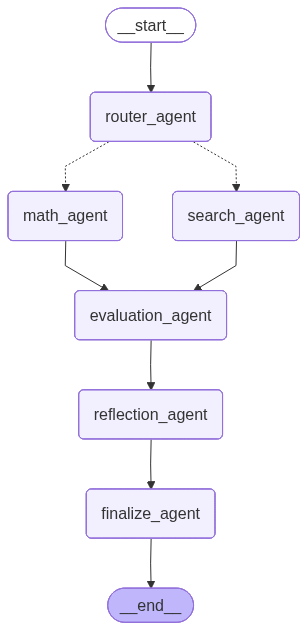


ROUTER AGENT: Initializing Query Processing


KeyboardInterrupt: Interrupted by user

In [13]:
if __name__ == "__main__":
    result, memory = main()